#### Scratchpad updates:

Data:  
 - SMOTE-upsampling

Models:
 - 6 basic models, little tuning
 - exploring accuracy, precision, recall, f1
 - tune RF to balance precision and recall
     - marginal increase in F1 scores
     - marginal decrease in accuracy


In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_df = pd.read_csv('credit_data.csv')

In [3]:
# drop unneeded columns
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

# current col names are X1, X2...add better col names
columns = ['Limit','Sex','Education','Marriage','Age','Hist_6',\
           'Hist_5','Hist_4','Hist_3','Hist_2','Hist_1','Bill_6',\
           'Bill_5','Bill_4','Bill_3','Bill_2','Bill_1','Pay_6',\
           'Pay_5','Pay_4','Pay_3','Pay_2','Pay_1','Default']
raw_df.columns = columns

# drop header from first row
raw_df = raw_df.drop([0]).reset_index()

# re-order the columns
columns=['Default','Limit','Sex','Education','Marriage','Age',\
         'Bill_1','Bill_2','Bill_3','Bill_4','Bill_5','Bill_6',\
         'Pay_1','Pay_2','Pay_3','Pay_4','Pay_5','Pay_6',\
         'Hist_1','Hist_2','Hist_3','Hist_4','Hist_5','Hist_6']
raw_df = raw_df[columns]

# replace encoded features with categorical values
raw_df = raw_df.astype(int)
raw_df['Sex'].replace([1,2],['Male','Female'], inplace=True)
raw_df['Education'].replace([0,1,2,3,4,5,6],['Others','Graduate','University','High_School','Others','Others','Others'], inplace=True)
raw_df['Marriage'].replace([0,1,2,3],['Others','Married','Single','Others'], inplace=True)

In [4]:
raw_df

,Default,Limit,Sex,Education,Marriage,Age,Bill_1,Bill_2,Bill_3,Bill_4,...,Pay_3,Pay_4,Pay_5,Pay_6,Hist_1,Hist_2,Hist_3,Hist_4,Hist_5,Hist_6
0,1,20000,Female,University,Married,24,0,0,0,689,...,0,0,689,0,-2,-2,-1,-1,2,2
1,1,120000,Female,University,Single,26,3261,3455,3272,2682,...,1000,1000,1000,0,2,0,0,0,2,-1
2,0,90000,Female,University,Single,34,15549,14948,14331,13559,...,1000,1000,1500,1518,0,0,0,0,0,0
3,0,50000,Female,University,Married,37,29547,28959,28314,49291,...,1100,1200,2019,2000,0,0,0,0,0,0
4,0,50000,Male,University,Married,57,19131,19146,20940,35835,...,9000,10000,36681,2000,0,0,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,220000,Male,High_School,Married,39,15980,31237,88004,208365,...,3047,5003,20000,8500,0,0,0,0,0,0
29996,0,150000,Male,High_School,Single,43,0,5190,8979,3502,...,129,8998,3526,1837,0,0,-1,-1,-1,-1
29997,1,30000,Male,University,Single,37,19357,20582,20878,2758,...,4200,22000,0,0,0,0,-1,2,3,4
29998,1,80000,Male,High_School,Married,41,48944,11855,52774,76304,...,1926,1178,3409,85900,-1,0,0,0,-1,1


## Add some new features
### Monthly Debt

In [5]:
raw_df['Debt_2'] = raw_df['Pay_2'] - raw_df['Bill_1']
raw_df['Debt_3'] = raw_df['Pay_3'] - raw_df['Bill_2']
raw_df['Debt_4'] = raw_df['Pay_4'] - raw_df['Bill_3']
raw_df['Debt_5'] = raw_df['Pay_5'] - raw_df['Bill_4']
raw_df['Debt_6'] = raw_df['Pay_6'] - raw_df['Bill_5']

### Debt Change

In [6]:
raw_df['Debt_delta'] = raw_df['Debt_6'] - raw_df['Debt_2']

## Look at class balance

percent default cases = 	22.12%
number non-default cases = 	23364
number default cases = 		6636


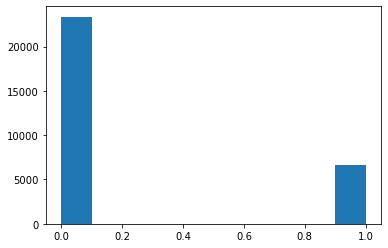

In [7]:
import matplotlib.pyplot as plt
plt.hist(raw_df['Default']);
print('percent default cases = \t{}%'.format(100*(raw_df['Default'] == 1).sum() / len(raw_df)))
print('number non-default cases = \t{}'.format((raw_df['Default'] == 0).sum()))
print('number default cases = \t\t{}'.format((raw_df['Default'] == 1).sum()))

## Split Train, test, val

In [8]:
# Separate train, val, and test data

from sklearn.model_selection import train_test_split

# Separate features from label
X = raw_df.drop(columns='Default')
y = raw_df['Default']

# Hold out 20% test data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4444)

# Hold out 25% of remainder for validation
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4444)

## Create dummies

In [9]:
# One hot encode categoricals for Train, (Val- skip), and Test sets

from sklearn.preprocessing import OneHotEncoder

# Define the categoricals
categoricals = ['Sex','Education','Marriage']

#
# Train data
#
# Initialize
ohe = OneHotEncoder(sparse=False)
# Create a matrix of encoded variables
cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])
# Turn the matrix into a dataframe
X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), # use real column names
                           index=X_train.index) # get index position form training data
# Combine encoded categoricals with the numeric training data
X_train_preprocessed = pd.concat([X_train.drop(columns=categoricals), X_train_ohe], axis=1)

#
# Val data - don't need when doing kfold cross val
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_val = ohe.fit_transform(x_val.loc[:, categoricals])
x_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_val.index)
x_val_preprocessed = pd.concat([x_val.drop(columns=categoricals), x_val_ohe], axis=1)

#
# Test data
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_test = ohe.fit_transform(x_test.loc[:, categoricals])
x_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_test.index)
x_test_preprocessed = pd.concat([x_test.drop(columns=categoricals), x_test_ohe], axis=1)

## Upsample training set with SMOTE

In [10]:
from imblearn.over_sampling import SMOTE
X_up_train_preprocessed, y_up_train = SMOTE(random_state=42).fit_sample(X_train_preprocessed, y_train)

In [11]:
from collections import Counter
Counter(y_up_train)

Counter({1: 14016, 0: 14016})

## Scale

In [12]:
# Scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_up_train_preprocessed)
X_up_train_preprocessed_scaled = scaler.transform(X_up_train_preprocessed)
x_val_preprocessed_scaled = scaler.transform(x_val_preprocessed)
x_test_preprocessed_scaled = scaler.transform(x_test_preprocessed)

## KNN (k: 1-20)

In [13]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_val=[]
acc_val=[]
prec_val=[]
rec_val=[]

for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_up_train_preprocessed_scaled, y_up_train)
    pred = knn.predict(x_val_preprocessed_scaled)
    k_val.append(k)
    acc_val.append(metrics.accuracy_score(y_val, pred))
    prec_val.append(metrics.precision_score(y_val, pred))
    rec_val.append(metrics.recall_score(y_val, pred))

knn_val_scores = pd.DataFrame(list(zip(k_val, acc_val, prec_val, rec_val)),\
                              columns=['k','acc', 'prec', 'rec'])

In [14]:
import pickle

# Pickle the knn scores
with open('knn_val_v2.pickle', 'wb') as to_write:
    pickle.dump(knn_val_scores, to_write)

In [15]:
# Read
import pickle
with open('knn_val_v2.pickle','rb') as read_file:
    knn_val_scores = pickle.load(read_file)

In [16]:
knn_val_scores

,k,acc,prec,rec
0,1,0.710333,0.376555,0.422483
1,2,0.756833,0.445067,0.291697
2,3,0.714167,0.395514,0.492285
3,4,0.757167,0.459732,0.402645
4,5,0.725167,0.413565,0.506245
5,6,0.761167,0.472136,0.448200
6,7,0.734833,0.429534,0.515062
7,8,0.763500,0.477896,0.460691
8,9,0.744167,0.445693,0.524614
9,10,0.764333,0.480558,0.481264


In [17]:
max_k = int(knn_val_scores.iloc[np.argmax(knn_val_scores['acc'])].k)

## Assess performance of different models

In [18]:

model_list = []
scores_list = []
fit_models = []

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=max_k)
knn.fit(X_up_train_preprocessed_scaled, y_up_train)
knn_score = knn.score(x_val_preprocessed_scaled,y_val)
model_list.append('KNN')
scores_list.append(knn_score)
fit_models.append(knn)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_up_train_preprocessed, y_up_train)
lr_score = lr.score(x_val_preprocessed,y_val)
model_list.append('LR')
scores_list.append(lr_score)
fit_models.append(lr)

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_up_train_preprocessed, y_up_train)
nb_score = nb.score(x_val_preprocessed,y_val)
model_list.append('NB')
scores_list.append(nb_score)
fit_models.append(nb)

from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_up_train_preprocessed_scaled, y_up_train)
svc_score = svc.score(x_val_preprocessed_scaled,y_val)
model_list.append('SVC')
scores_list.append(svc_score)
fit_models.append(svc)
    
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_up_train_preprocessed, y_up_train)
dt_score = dt.score(x_val_preprocessed,y_val)
model_list.append('DT')
scores_list.append(dt_score)
fit_models.append(dt)         
    
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_up_train_preprocessed, y_up_train)
rf_score = rf.score(x_val_preprocessed,y_val)
model_list.append('RF')
scores_list.append(rf_score)
fit_models.append(rf)            
    
six_basic_models_val = pd.DataFrame(list(zip(model_list, scores_list)),\
                              columns=['model','acc'])


In [19]:
import pickle
# pickle the scores
with open('six_models_v2.pickle', 'wb') as to_write:
    pickle.dump(six_basic_models_val, to_write)

In [20]:
# pickle the models
with open('six_fit_models_v2.pickle', 'wb') as to_write:
    pickle.dump(fit_models, to_write)

In [21]:
# Read the scores
import pickle
with open('six_models_v2.pickle','rb') as read_file:
    six_basic_models_val = pickle.load(read_file)

In [22]:
# Read the models
import pickle
with open('six_fit_models_v2.pickle','rb') as read_file:
    fit_models = pickle.load(read_file)

In [23]:
six_basic_models_val

,model,acc
0,KNN,0.768500
1,LR,0.554667
2,NB,0.332000
3,SVC,0.808667
4,DT,0.712667
5,RF,0.803667


In [24]:
# unpack the pickled models:
knn = fit_models[0]
lr = fit_models[1]
nb = fit_models[2]
svc = fit_models[3]
dt = fit_models[4]
rf = fit_models[5]

In [25]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4639
           1       0.49      0.50      0.49      1361

    accuracy                           0.77      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.77      0.77      0.77      6000



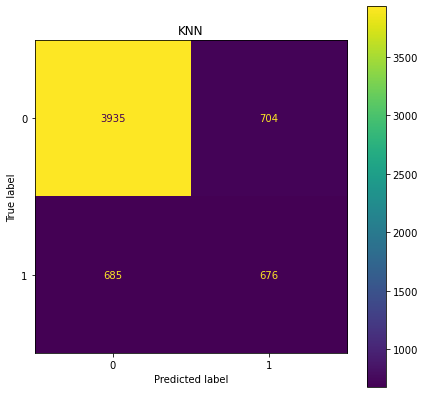

In [26]:
y_preds = knn.predict(x_val_preprocessed_scaled)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, x_val_preprocessed_scaled, y_val, ax=ax)
plt.title('KNN');

              precision    recall  f1-score   support

           0       0.86      0.51      0.64      4639
           1       0.30      0.71      0.42      1361

    accuracy                           0.55      6000
   macro avg       0.58      0.61      0.53      6000
weighted avg       0.73      0.55      0.59      6000



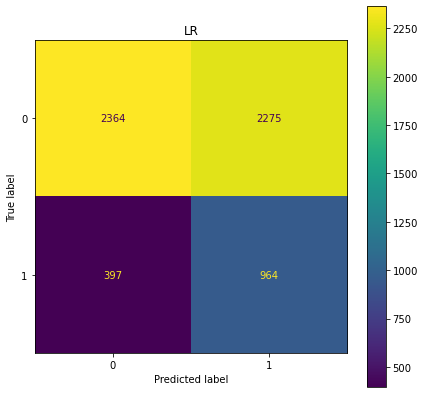

In [27]:
y_preds = lr.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, x_val_preprocessed, y_val, ax=ax)
plt.title('LR');

              precision    recall  f1-score   support

           0       0.87      0.16      0.27      4639
           1       0.24      0.92      0.38      1361

    accuracy                           0.33      6000
   macro avg       0.55      0.54      0.33      6000
weighted avg       0.72      0.33      0.30      6000



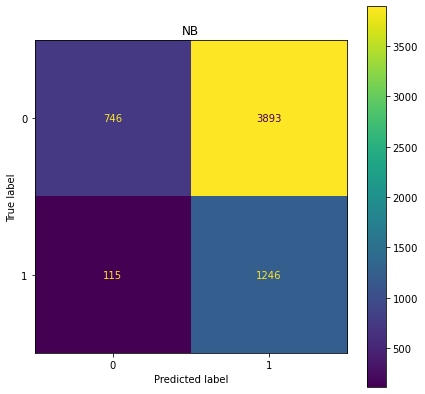

In [28]:
y_preds = nb.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nb, x_val_preprocessed, y_val, ax=ax)
plt.title('NB');

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4639
           1       0.60      0.46      0.52      1361

    accuracy                           0.81      6000
   macro avg       0.73      0.69      0.70      6000
weighted avg       0.80      0.81      0.80      6000



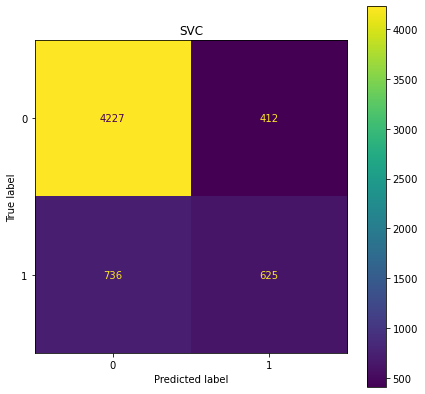

In [29]:
y_preds =svc.predict(x_val_preprocessed_scaled)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svc, x_val_preprocessed_scaled, y_val, ax=ax)
plt.title('SVC');

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4639
           1       0.38      0.44      0.41      1361

    accuracy                           0.71      6000
   macro avg       0.61      0.62      0.61      6000
weighted avg       0.73      0.71      0.72      6000



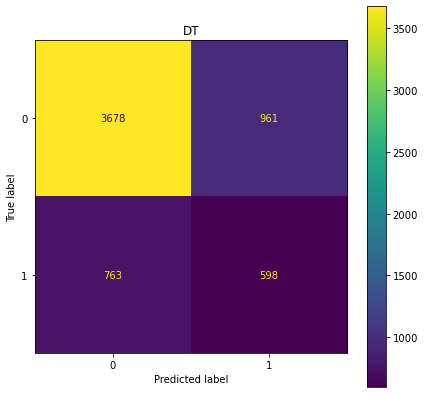

In [30]:
y_preds =dt.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(dt, x_val_preprocessed, y_val, ax=ax)
plt.title('DT');

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      4639
           1       0.59      0.43      0.50      1361

    accuracy                           0.80      6000
   macro avg       0.72      0.67      0.69      6000
weighted avg       0.79      0.80      0.79      6000



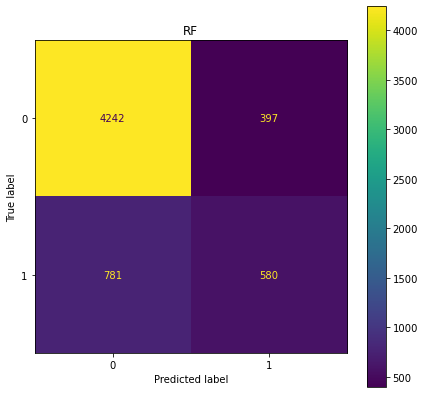

In [31]:
y_preds =rf.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rf, x_val_preprocessed, y_val, ax=ax)
plt.title('RF');

ROC AUC score =  0.727413763037367


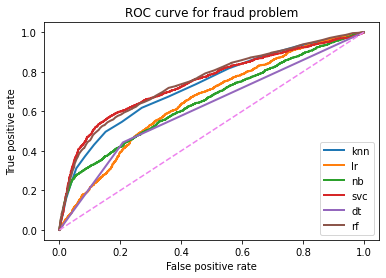

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve

knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_val, knn.predict_proba(x_val_preprocessed_scaled)[:,1])
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_val, lr.predict_proba(x_val_preprocessed)[:,1])
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_val, nb.predict_proba(x_val_preprocessed)[:,1])
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_val, svc.predict_proba(x_val_preprocessed_scaled)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_val, dt.predict_proba(x_val_preprocessed)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, rf.predict_proba(x_val_preprocessed)[:,1])

plt.plot(knn_fpr, knn_tpr,lw=2, label='knn')
plt.plot(lr_fpr, lr_tpr,lw=2, label='lr')
plt.plot(nb_fpr, nb_tpr,lw=2, label='nb')
plt.plot(svc_fpr, svc_tpr,lw=2, label='svc')
plt.plot(dt_fpr, dt_tpr,lw=2, label='dt')
plt.plot(rf_fpr, rf_tpr,lw=2, label='rf')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(x_val_preprocessed_scaled)[:,1]))

In [33]:
print("KNN ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(x_val_preprocessed_scaled)[:,1]))
print("LR ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(x_val_preprocessed)[:,1]))
print("NB ROC AUC score = ", roc_auc_score(y_val, nb.predict_proba(x_val_preprocessed)[:,1]))
print("SVC ROC AUC score = ", roc_auc_score(y_val, svc.predict_proba(x_val_preprocessed_scaled)[:,1]))
print("DT ROC AUC score = ", roc_auc_score(y_val, dt.predict_proba(x_val_preprocessed)[:,1]))
print("RF ROC AUC score = ", roc_auc_score(y_val, rf.predict_proba(x_val_preprocessed)[:,1]))

KNN ROC AUC score =  0.727413763037367
LR ROC AUC score =  0.6528459872603596
NB ROC AUC score =  0.6534915696537629
SVC ROC AUC score =  0.7452467887581868
DT ROC AUC score =  0.6169760135097144
RF ROC AUC score =  0.7494932035664151


## Explore RF parameters

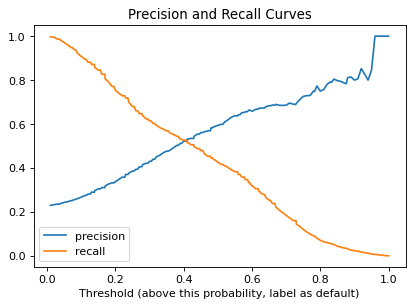

In [34]:
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, threshold_curve = \
precision_recall_curve(y_val, rf.predict_proba(x_val_preprocessed)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as default)');
plt.title('Precision and Recall Curves');

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4639
           1       0.53      0.52      0.52      1361

    accuracy                           0.79      6000
   macro avg       0.70      0.69      0.69      6000
weighted avg       0.78      0.79      0.79      6000



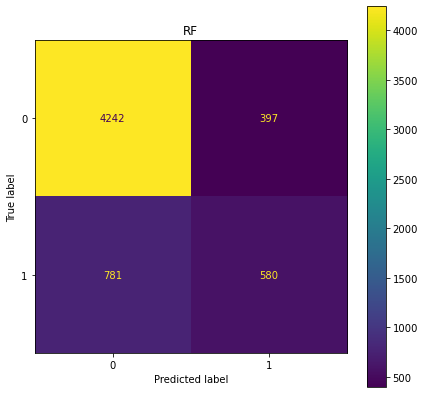

In [35]:
# This is the updated threshold where precision and recall cross over
threshold = threshold_curve[np.argmin(abs(precision_curve - recall_curve))]
y_preds = (rf.predict_proba(x_val_preprocessed)[:, 1] > threshold)
print(classification_report(y_val, y_preds))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rf, x_val_preprocessed, y_val, ax=ax)
plt.title('RF');